In [1]:
%matplotlib inline

# Comparing Ping (ICMP) vs. Echo (gRPC) Latencies 

This notebook parses the output of the ping protocol and the orca echo protocol and compares the distribution of latencies from each. 

In [2]:
import os
import re 

import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 

from scipy import stats

sns.set_context('notebook')
sns.set_style('whitegrid')

In [3]:
# Paths to input files 
FIXTURES = os.path.normpath(os.path.join(os.getcwd(), "..", "fixtures")) 
PINGS = os.path.join(FIXTURES, "ping.txt")
ECHOS = os.path.join(FIXTURES, "echo.txt")

In [4]:
# Parsing for the log files 
pingre = re.compile(r'(\d+) bytes from ([\w\d\.]+): icmp_seq=(\d+) ttl=(\d+) time=([\d\.]+) ms')
echore = re.compile(r'([\d\/]+) ([\d\:]+) received (\d+) bytes from (\w+) \(([\w\.\:]+)\) order=(\d+) seq=(\d+) time=([\d\.]+)ms')


def parse(line, ping=False, echo=False):
    if ping:
        regex = pingre 
        idx = 4
    elif echo:
        regex = echore 
        idx = 7
    else:
        raise ValueError("Specify ping or echo line")
    
    match = regex.match(line)
    if match is not None:
        latency = match.groups()[idx]
        return float(latency)
        
    return None 


def load_data(pings=PINGS, echos=ECHOS):
    """
    Load and parse the two datasets 
    """
    
    for idx, path in enumerate((pings, echos)):
        if path is None: continue 
        name, _ = os.path.splitext(os.path.basename(path))
            
        with open(path, 'r') as fobj:
            for line in fobj:
                latency = parse(line, ping=idx==0, echo=idx==1)
                if latency is not None:
                    yield name, latency 


# Remove outliers 
def remove_outliers(df, passes=1):
    """
    Removes all data points that are less than 3 standard deviations from the mean. 
    Can run multiple passes to remove data at different granularities. 
    """
    total = len(df)
    
    for _ in range(passes):
        df = df[(np.abs(stats.zscore(df['latency (ms)'])) < 3)]
    
    print("Removed {} rows from {} original".format(total-len(df), total))
    return df

In [5]:
# Load the dataset 
df = pd.DataFrame(load_data())
df.columns = ['protocol', 'latency (ms)']
df.head()

,protocol,latency (ms)
0,ping,13.215
1,ping,11.645
2,ping,14.277
3,ping,11.352
4,ping,13.751


In [6]:
# Remove outliers 
tdf = remove_outliers(df, passes=2)

Removed 85 rows from 7190 original


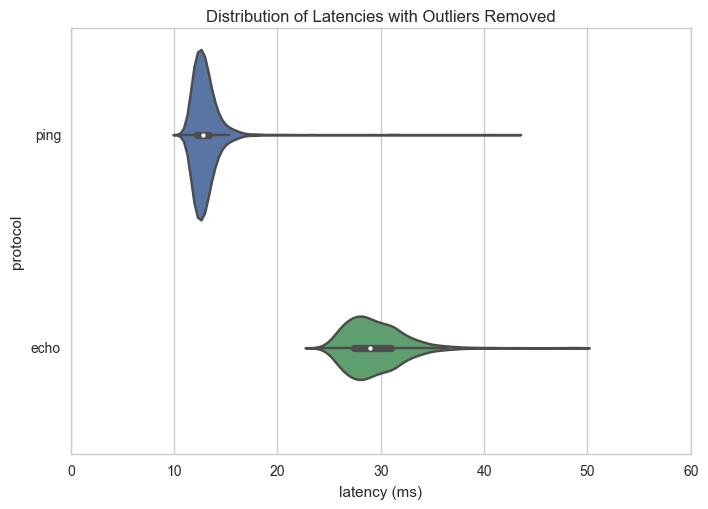

In [7]:
g = sns.violinplot(x='latency (ms)', y='protocol', data=tdf)
g.set_title("Distribution of Latencies with Outliers Removed")

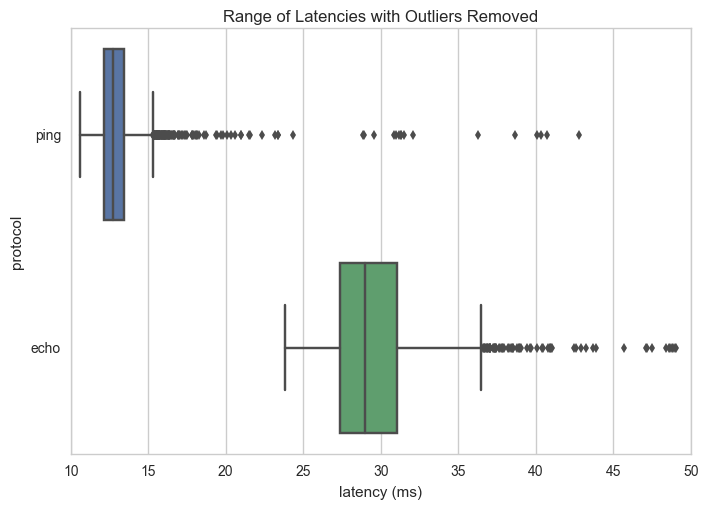

In [8]:
g = sns.boxplot(x='latency (ms)', y='protocol', data=tdf)
g.set_title("Range of Latencies with Outliers Removed")

In [9]:
tdf[df.protocol == 'ping'].describe()

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,latency (ms)
count,3567.000000
mean,13.037264
std,1.877744
min,10.616000
25%,12.169000
50%,12.747000
75%,13.422500
max,42.806000


In [10]:
tdf[df.protocol == 'echo'].describe()

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,latency (ms)
count,3538.000000
mean,29.431315
std,2.908863
min,23.806328
25%,27.366130
50%,28.989888
75%,31.016401
max,49.039899
